In [245]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-white')

from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

## Cargar datos

In [3]:
df = pd.read_csv('caudal_extra.csv',
                 index_col=0,
                 parse_dates=[11],
                 infer_datetime_format=True)

df.sort_values(['codigo_estacion', 'fecha'], inplace=True)

df.head()

/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,codigo_estacion,institucion,fuente,nombre,altura,latitud,longitud,codigo_cuenca,nombre_sub_cuenca,cantidad_observaciones,fecha,caudal,gauge_id,gauge_name,precip_promedio,temp_max_promedio
90656,1020003,DGA,dga_web,Rio Lauca En Estancia El Lago,4370,-18.2325,-69.331902,10,Rio Lauca,15268,1963-04-01,0.284,1020003,Rio Lauca En Estancia El Lago,0.075,NaN
88201,1020003,DGA,dga_web,Rio Lauca En Estancia El Lago,4370,-18.2325,-69.331902,10,Rio Lauca,15268,1963-04-02,0.320,1020003,Rio Lauca En Estancia El Lago,0.875,NaN
88700,1020003,DGA,dga_web,Rio Lauca En Estancia El Lago,4370,-18.2325,-69.331902,10,Rio Lauca,15268,1963-04-03,0.398,1020003,Rio Lauca En Estancia El Lago,0.050,NaN
88462,1020003,DGA,dga_web,Rio Lauca En Estancia El Lago,4370,-18.2325,-69.331902,10,Rio Lauca,15268,1963-04-04,0.422,1020003,Rio Lauca En Estancia El Lago,0.375,NaN
96534,1020003,DGA,dga_web,Rio Lauca En Estancia El Lago,4370,-18.2325,-69.331902,10,Rio Lauca,15268,1963-04-05,0.370,1020003,Rio Lauca En Estancia El Lago,2.750,NaN


In [4]:
df.dtypes

codigo_estacion                    int64
institucion                       object
fuente                            object
nombre                            object
altura                             int64
latitud                          float64
longitud                         float64
codigo_cuenca                      int64
nombre_sub_cuenca                 object
cantidad_observaciones             int64
fecha                     datetime64[ns]
caudal                           float64
gauge_id                           int64
gauge_name                        object
precip_promedio                  float64
temp_max_promedio                float64
dtype: object

In [5]:
data_cols = {
        'caudal': {'unidad':'m3/s', 'nombre': 'caudal'},
        'precip_promedio': {'unidad':'mm', 'nombre': 'precipitaciones'},
        'temp_max_promedio': {'unidad':'C', 'nombre': 'temperatura'}
               }

## Análisis exploratorio

In [226]:
df[list(data_cols.keys())].describe()

,caudal,precip_promedio,temp_max_promedio
count,1.411180e+06,1.383413e+06,1.259617e+06
mean,9.552229e+01,1.921009e+00,1.921110e+01
std,2.526337e+02,7.361936e+00,7.307081e+00
min,0.000000e+00,0.000000e+00,-1.905000e+01
25%,1.250000e+00,0.000000e+00,1.370000e+01
50%,8.950000e+00,0.000000e+00,1.908429e+01
75%,6.970000e+01,0.000000e+00,2.520000e+01
max,1.580500e+04,2.586000e+02,4.150000e+01


In [225]:
df[list(data_cols.keys())].isnull().sum()/len(df)

caudal               0.000000
precip_promedio      0.019676
temp_max_promedio    0.107402
dtype: float64

Por la forma en que se unieron los datos de caudal de las cuencas con las estaciones meteorológicas, pueden haber cuencas que no tengan ninguna estación de temperatura o precipitación asociada. Una forma de mejorar esto podría ser interpolando la temperatura o precipitación de estaciones cercanas.

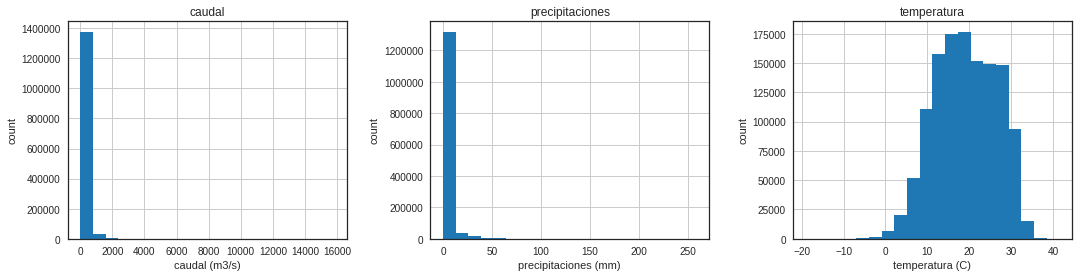

In [236]:
fig, axes = plt.subplots(1,3,figsize=(18,4))
plt.subplots_adjust(wspace=.3)

for i, col in enumerate(data_cols.keys()):
    
    df[col].hist(ax=axes[i], bins=20)
    
    axes[i].set_title(data_cols[col]['nombre'])
    axes[i].set_ylabel('count')
    axes[i].set_xlabel(('{} ({})'.format(data_cols[col]['nombre'], data_cols[col]['unidad'])))

plt.show()

Las distribuciones de caudal y precipitaciones son sesgadas hacia la derecha, con muchos valores bajos y pocos valores altos. La temperatura tiene una distribución más normal.

In [242]:
df.groupby('codigo_estacion')['fecha'].max().sort_values().head(15)

codigo_estacion
4716001   1983-02-18
4550003   1983-03-31
7355001   1983-09-14
4535002   1984-05-15
4540001   1984-07-08
8133001   1984-08-31
5421001   1984-12-31
5730005   1987-12-31
3430002   1988-01-11
2103003   1989-03-30
3826001   1997-08-17
8106001   1998-11-30
4714001   2003-09-26
2104003   2006-03-28
5734001   2006-10-11
Name: fecha, dtype: datetime64[ns]

In [243]:
(df.groupby('codigo_estacion')['fecha'].max() > '2018').mean()

0.45864661654135336

Algunas cuencas tienen datos hasta los 80s solamente, y solo el 45% de las cuencas tiene datos hasta 2018.

In [7]:
df.codigo_estacion.unique()

array([ 1020003,  1021001,  1050004,  1211001,  2103003,  2104002,
        2104003,  2105001,  2105002,  2105005,  2105007,  2110001,
        2110002,  2110004,  2110031,  2112005,  2112006,  2112007,
        2120001,  3430001,  3430002,  3431001,  3434003,  3450001,
        3453001,  3804002,  3806001,  3820001,  3820002,  3820003,
        3825001,  3826001,  4308001,  4320001,  4323001,  4335001,
        4503001,  4513001,  4523002,  4535002,  4537001,  4540001,
        4550003,  4558001,  4711001,  4714001,  4716001,  4716004,
        4726001,  4730001,  5221002,  5410002,  5410005,  5421001,
        5423003,  5704002,  5710001,  5721016,  5730005,  5734001,
        5737002,  5746001,  5748001,  6019003,  6034023,  6035001,
        7116001,  7123001,  7317003,  7322001,  7332001,  7335001,
        7335002,  7355001,  7355002,  7357002,  7359001,  7379002,
        7381001,  7383001,  8106001,  8106002,  8132001,  8133001,
        8135002,  8140002,  8141001,  8304001,  8307002,  8308

## Graficos de series de tiempo

In [10]:
def time_plot_una_estacion(codigo_estacion, columna, fecha_min, fecha_max):
    
    temp_df = df.loc[df.codigo_estacion == codigo_estacion, ['fecha', columna]]
    
    temp_df.set_index('fecha', inplace=True)
    
    temp_df = temp_df[fecha_min:fecha_max]
    
    if len(temp_df):
    
        nombre_cuenca = df.loc[df.codigo_estacion == codigo_estacion, 'nombre_sub_cuenca'].unique()[0]

        fig, ax = plt.subplots(figsize=(15,6))

        temp_df.plot(ax=ax, legend=None)

        ax.set_title('{} en {}'.format(data_cols[columna]['nombre'].title(), nombre_cuenca))
        ax.set_ylabel('{} ({})'.format(data_cols[columna]['nombre'], data_cols[columna]['unidad']))
        
    else:
        
        print('No existen datos para esa cuenca en las fechas seleccionadas')
    

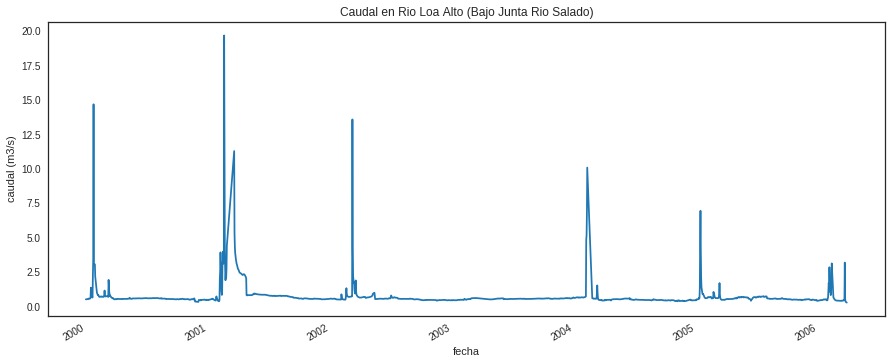

In [231]:
time_plot_una_estacion(2104003, 'caudal', '2000', '2010')

In [12]:
def time_plot_estaciones_varias_columnas(codigo_estacion, columnas, fecha_min, fecha_max):
    
    temp_df = df.loc[df.codigo_estacion == codigo_estacion, ['fecha'] + columnas]
    
    temp_df.set_index('fecha', inplace=True)
    
    temp_df = temp_df[fecha_min:fecha_max]
    
    temp_df = (temp_df - temp_df.mean())/temp_df.std()
    
    if len(temp_df):
    
        nombre_cuenca = df.loc[df.codigo_estacion == codigo_estacion, 'nombre_sub_cuenca'].unique()[0]

        fig, ax = plt.subplots(figsize=(15,6))

        for col in columnas:
            temp_df[col].plot(ax=ax,
                              label='{} ({})'.format(data_cols[col]['nombre'], data_cols[col]['unidad']))
            
        ax.legend()

        ax.set_title('{}'.format(nombre_cuenca))
        ax.set_ylabel('unidad normalizada')
        
    else:
        
        print('No existen datos para esa cuenca en las fechas seleccionadas')

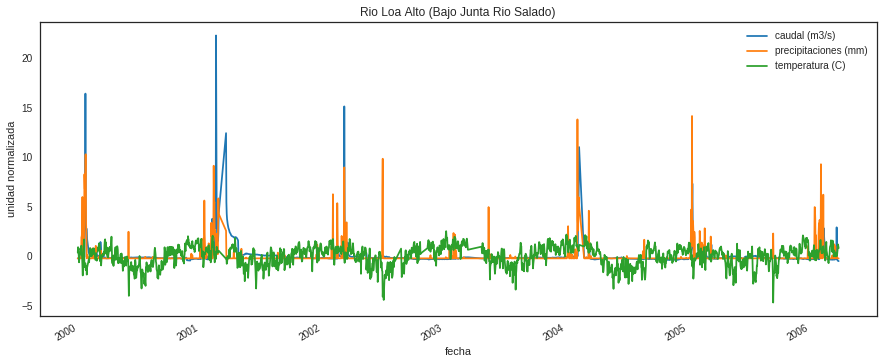

In [244]:
time_plot_estaciones_varias_columnas(2104003, ['caudal', 'precip_promedio', 'temp_max_promedio'], '2000', '2010')

**Nota:** En este gráfico decidí normalizar los datos dejando todos con media 0 y desviación estándar 1.

## Caudal/Temperatura/Precipitación extrema

#### Creación variables

Para simplificar las estaciones calcularé el quarter correspondiente a la fecha.

In [14]:
df['quarter'] = (df.fecha.dt.month-1)//3 + 1

Calcular percentil 95 para cada estacion en cada quarter, para las 3 variables.

In [15]:
percentiles_95 = df.groupby(['codigo_estacion', 'quarter'])[list(data_cols.keys())].quantile(.95)

percentiles_95.columns = [x + '_p95' for x in data_cols.keys()]

percentiles_95.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4315: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_values = np.vstack(map(np.asarray, values))


caudal_p95  precip_promedio_p95  \
codigo_estacion quarter                                    
1020003         1            1.7650            10.645000   
                2            0.1990             1.107000   
                3            0.1990             0.000000   
                4            0.1246             4.116000   
1021001         1           15.2000            10.623561   

                         temp_max_promedio_p95  
codigo_estacion quarter                         
1020003         1                    15.891000  
                2                    14.373750  
                3                    14.000000  
                4                    16.782001  
1021001         1                    16.000000

Unir al Dataframe original para facilitar la comparación.

In [16]:
df = df.merge(percentiles_95, left_on=['codigo_estacion', 'quarter'], right_index=True)

df[percentiles_95.columns].isnull().sum()

caudal_p95                 0
precip_promedio_p95      640
temp_max_promedio_p95      0
dtype: int64

Vemos que hay algunos valores missing, esto viene 'heredado' del inicio con los valores faltantes.



In [17]:
for col in data_cols.keys():
    df[col + '_extremo'] = (df[col] > df[col + '_p95']).astype(int)
    
df[[x + '_extremo' for x in data_cols.keys()]].mean()

caudal_extremo               0.049811
precip_promedio_extremo      0.042620
temp_max_promedio_extremo    0.043361
dtype: float64

Me parece razonable usar percentil 95 para identificar valores extremos. Otra alternativa sería clasificar como extremo valores que estén sobre 2 desviaciones estándar de la media.

Separar el calculo del percentil por estaciones es útil para identificar valores extremos para cada estación. El problema que veo al hacer esto es en el caso de la variable caudal. En un lugar seco en verano, un caudal extremo segun nuestra definición puede seguir siendo un caudal bajo para esa cuenca y que no represente una amenaza de desborde o aluvión. Sería ideal usar una medida empirica de cuanto es el máximo caudal seguro de una cuenca.

## Análisis variable caudal extremo

Por la forma en que está construida la variable, todas las cuencas tendrán el mismo porcentaje de eventos de caudal extremo. No podemos hacer comparaciones a nivel general, pero si podemos analizar como estos han variado a través del tiempo.

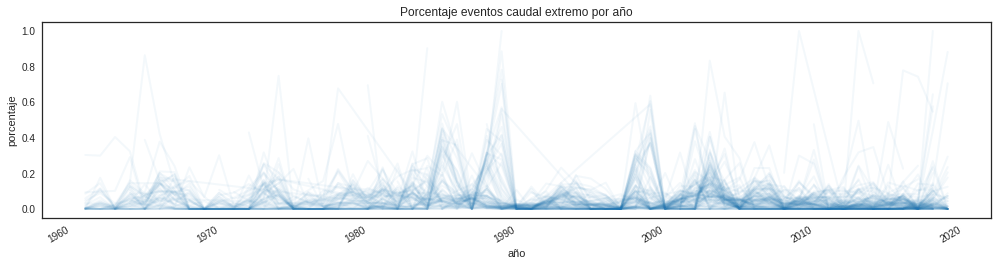

In [257]:
fig, ax = plt.subplots(figsize=(17,4))

df_caudal_extremo = df.groupby(['codigo_estacion', pd.Grouper(key='fecha', freq='A')])['caudal_extremo'].mean()

for estacion in df.codigo_estacion.unique():
    df_caudal_extremo.loc[(estacion,)].plot(ax=ax, color='tab:blue', alpha=0.05, lw=2)

ax.set_title('Porcentaje eventos caudal extremo por año')
ax.set_ylabel('porcentaje')
ax.set_xlabel('año')

plt.show()

Cada línea en el gráfico anterior corresponde a la serie de tiempo del porcentaje de eventos de caudal extremo para una cuenca. Podemos ver que hay años en que muchas cuencas concentran un alto porcentaje de sus eventos de caudal extremo.

## Eventos extremos a través del tiempo

In [18]:
eventos_extremos_yearly = df.groupby(pd.Grouper(key='fecha', freq='A'))[[x + '_extremo' for x in data_cols.keys()]].mean()
eventos_extremos_yearly.head()

,caudal_extremo,precip_promedio_extremo,temp_max_promedio_extremo
fecha,,,
1960-12-31,0.024852,0.017938,0.001303
1961-12-31,0.047556,0.033259,0.001622
1962-12-31,0.022085,0.017722,0.010997
1963-12-31,0.066237,0.053125,0.009591
1964-12-31,0.044382,0.023251,0.007208


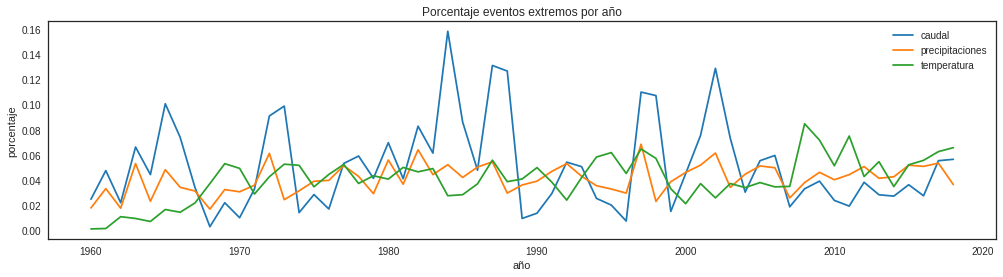

In [248]:
fig, ax = plt.subplots(figsize=(17,4))

for col in data_cols.keys():
    eventos_extremos_yearly[col + '_extremo'].plot(ax=ax, label=data_cols[col]['nombre'])

ax.legend()

ax.set_title('Porcentaje eventos extremos por año')
ax.set_ylabel('porcentaje')
ax.set_xlabel('año')

plt.show()

En el gráfico se podría decir que los eventos de temperatura extrema se han vuelto levemente más comunes. En el caso de las precipitaciones y caudal es menos claro, yo diría que la tendencia es constante. Si llama la atención que hay algunos años que concentran muchos eventos de caudal extremo, y no se ve que estos coincidan con un aumento en eventos de precipitaciones o temperaturas extremas.

## Predicción de caudal extremo.

Para realizar la predicción tiene sentido usar los datos de caudal, temperatura y precipitaciones hasta el día anterior. De esta forma nuestro modelo podria ser usado para predecir el caudal del día seguiente y generar una alerta en caso de que prediga un caudal extremo.

En el caso de la temperatura y precipitaciones, teóricamente podríamos usar además el pronóstico del tiempo (pronosticado el día anterior del que queremos predecir). Sin embargo, para el proceso de train y test de nuestro modelo necesitaríamos también tener este dato histórico.

#### Preparación de datos

Usaré los datos de caudal, temperatura y precipitaciones de los 7 días anteriores para realizar la predicción. Para esto generaré algunas variables adicionales para cada una de los datos que tenemos:

* Promedio en los 7 dias anteriores
* Desviación estandar en los 7 días anteriores
* Tendencia en los 7 días anteriores (sacando la pendiente de una regresión lineal)
* Porcentaje de días estremos en los 7 días anteriores

Además, sólo incluiré directamente el dato de caudal, temperatura y precipitaciones del día anterior.

In [28]:
rolling_mean = df.groupby('codigo_estacion').apply(lambda x: x.set_index('fecha')) \
                                            .rolling(7, min_periods=7)[list(data_cols.keys())].mean()

rolling_mean.columns = [x + '_rolling_mean' for x in data_cols.keys()]

rolling_mean.reset_index(inplace=True)

rolling_mean.head(20)

,codigo_estacion,fecha,caudal_rolling_mean,precip_promedio_rolling_mean,temp_max_promedio_rolling_mean
0,1020003,1963-04-01,NaN,NaN,NaN
1,1020003,1963-04-02,NaN,NaN,NaN
2,1020003,1963-04-03,NaN,NaN,NaN
3,1020003,1963-04-04,NaN,NaN,NaN
4,1020003,1963-04-05,NaN,NaN,NaN
5,1020003,1963-04-06,NaN,NaN,NaN
6,1020003,1963-04-07,0.364143,1.410714,NaN
7,1020003,1963-04-08,0.349857,1.400000,NaN
8,1020003,1963-04-09,0.327286,1.275000,NaN
9,1020003,1963-04-10,0.293286,1.267857,NaN


In [30]:
rolling_slope = df.groupby('codigo_estacion').apply(lambda x: x.set_index('fecha')) \
                                             .rolling(7, min_periods=7)[list(data_cols.keys())] \
                                             .apply(lambda x: linregress(range(7), x)[0])

rolling_slope.columns = [x + '_rolling_slope' for x in data_cols.keys()]

rolling_slope.reset_index(inplace=True)

rolling_slope.head(20)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  This is separate from the ipykernel package so we can avoid doing imports until


,codigo_estacion,fecha,caudal_rolling_slope,precip_promedio_rolling_slope,temp_max_promedio_rolling_slope
0,1020003,1963-04-01,NaN,NaN,NaN
1,1020003,1963-04-02,NaN,NaN,NaN
2,1020003,1963-04-03,NaN,NaN,NaN
3,1020003,1963-04-04,NaN,NaN,NaN
4,1020003,1963-04-05,NaN,NaN,NaN
5,1020003,1963-04-06,NaN,NaN,NaN
6,1020003,1963-04-07,0.009929,0.445536,NaN
7,1020003,1963-04-08,-0.020821,0.103571,NaN
8,1020003,1963-04-09,-0.045214,-0.121429,NaN
9,1020003,1963-04-10,-0.053036,-0.433036,NaN


In [31]:
rolling_std = df.groupby('codigo_estacion').apply(lambda x: x.set_index('fecha')) \
                                            .rolling(7, min_periods=7)[list(data_cols.keys())].std()

rolling_std.columns = [x + '_rolling_std' for x in data_cols.keys()]

rolling_std.reset_index(inplace=True)

rolling_std.head(20)

,codigo_estacion,fecha,caudal_rolling_std,precip_promedio_rolling_std,temp_max_promedio_rolling_std
0,1020003,1963-04-01,NaN,NaN,NaN
1,1020003,1963-04-02,NaN,NaN,NaN
2,1020003,1963-04-03,NaN,NaN,NaN
3,1020003,1963-04-04,NaN,NaN,NaN
4,1020003,1963-04-05,NaN,NaN,NaN
5,1020003,1963-04-06,NaN,NaN,NaN
6,1020003,1963-04-07,0.069853,2.035459,NaN
7,1020003,1963-04-08,0.094760,2.043842,NaN
8,1020003,1963-04-09,0.118820,2.107081,NaN
9,1020003,1963-04-10,0.128842,2.112005,NaN


In [32]:
rolling_extremo = df.groupby('codigo_estacion').apply(lambda x: x.set_index('fecha')) \
                                            .rolling(7, min_periods=7)[[x + '_extremo' for x in data_cols.keys()]].mean()

rolling_extremo.columns = [x + '_rolling_extremo' for x in data_cols.keys()]

rolling_extremo.reset_index(inplace=True)

rolling_extremo.head(20)

,codigo_estacion,fecha,caudal_rolling_extremo,precip_promedio_rolling_extremo,temp_max_promedio_rolling_extremo
0,1020003,1963-04-01,NaN,NaN,NaN
1,1020003,1963-04-02,NaN,NaN,NaN
2,1020003,1963-04-03,NaN,NaN,NaN
3,1020003,1963-04-04,NaN,NaN,NaN
4,1020003,1963-04-05,NaN,NaN,NaN
5,1020003,1963-04-06,NaN,NaN,NaN
6,1020003,1963-04-07,1.000000,0.285714,0.0
7,1020003,1963-04-08,0.857143,0.285714,0.0
8,1020003,1963-04-09,0.714286,0.285714,0.0
9,1020003,1963-04-10,0.571429,0.285714,0.0


In [40]:
final_df = df[['codigo_estacion', 'fecha', 'caudal_extremo'] + list(data_cols.keys())]

final_df = final_df.merge(rolling_mean, on=['codigo_estacion', 'fecha'])
final_df = final_df.merge(rolling_std, on=['codigo_estacion', 'fecha'])
final_df = final_df.merge(rolling_slope, on=['codigo_estacion', 'fecha'])
final_df = final_df.merge(rolling_extremo, on=['codigo_estacion', 'fecha'])

final_df.head(20)

,codigo_estacion,fecha,caudal_extremo,caudal,precip_promedio,temp_max_promedio,caudal_rolling_mean,precip_promedio_rolling_mean,temp_max_promedio_rolling_mean,caudal_rolling_std,precip_promedio_rolling_std,temp_max_promedio_rolling_std,caudal_rolling_slope,precip_promedio_rolling_slope,temp_max_promedio_rolling_slope,caudal_rolling_extremo,precip_promedio_rolling_extremo,temp_max_promedio_rolling_extremo
0,1020003,1963-04-01,1,0.284,0.075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1020003,1963-04-02,1,0.320,0.875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1020003,1963-04-03,1,0.398,0.050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1020003,1963-04-04,1,0.422,0.375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1020003,1963-04-05,1,0.370,2.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1020003,1963-04-06,1,0.467,5.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1020003,1963-04-07,1,0.288,0.250,NaN,0.364143,1.410714,NaN,0.069853,2.035459,NaN,0.009929,0.445536,NaN,1.000000,0.285714,0.0
7,1020003,1963-04-08,0,0.184,0.000,NaN,0.349857,1.400000,NaN,0.094760,2.043842,NaN,-0.020821,0.103571,NaN,0.857143,0.285714,0.0
8,1020003,1963-04-09,0,0.162,0.000,NaN,0.327286,1.275000,NaN,0.118820,2.107081,NaN,-0.045214,-0.121429,NaN,0.714286,0.285714,0.0
9,1020003,1963-04-10,0,0.160,0.000,NaN,0.293286,1.267857,NaN,0.128842,2.112005,NaN,-0.053036,-0.433036,NaN,0.571429,0.285714,0.0


Como queremos predecir el caudal extremo del día siguiente, debemos mover la columna una posición hacia arriba.

In [41]:
final_df['caudal_extremo'] = final_df['caudal_extremo'].shift(-1)

final_df.head(20)

,codigo_estacion,fecha,caudal_extremo,caudal,precip_promedio,temp_max_promedio,caudal_rolling_mean,precip_promedio_rolling_mean,temp_max_promedio_rolling_mean,caudal_rolling_std,precip_promedio_rolling_std,temp_max_promedio_rolling_std,caudal_rolling_slope,precip_promedio_rolling_slope,temp_max_promedio_rolling_slope,caudal_rolling_extremo,precip_promedio_rolling_extremo,temp_max_promedio_rolling_extremo
0,1020003,1963-04-01,1.0,0.284,0.075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1020003,1963-04-02,1.0,0.320,0.875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1020003,1963-04-03,1.0,0.398,0.050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1020003,1963-04-04,1.0,0.422,0.375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1020003,1963-04-05,1.0,0.370,2.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1020003,1963-04-06,1.0,0.467,5.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1020003,1963-04-07,0.0,0.288,0.250,NaN,0.364143,1.410714,NaN,0.069853,2.035459,NaN,0.009929,0.445536,NaN,1.000000,0.285714,0.0
7,1020003,1963-04-08,0.0,0.184,0.000,NaN,0.349857,1.400000,NaN,0.094760,2.043842,NaN,-0.020821,0.103571,NaN,0.857143,0.285714,0.0
8,1020003,1963-04-09,0.0,0.162,0.000,NaN,0.327286,1.275000,NaN,0.118820,2.107081,NaN,-0.045214,-0.121429,NaN,0.714286,0.285714,0.0
9,1020003,1963-04-10,0.0,0.160,0.000,NaN,0.293286,1.267857,NaN,0.128842,2.112005,NaN,-0.053036,-0.433036,NaN,0.571429,0.285714,0.0


In [43]:
final_df.isnull().sum()

codigo_estacion                           0
fecha                                     0
caudal_extremo                            1
caudal                                    0
precip_promedio                       27767
temp_max_promedio                    151563
caudal_rolling_mean                       6
precip_promedio_rolling_mean          29635
temp_max_promedio_rolling_mean       176412
caudal_rolling_std                        6
precip_promedio_rolling_std           29635
temp_max_promedio_rolling_std        176412
caudal_rolling_slope                      6
precip_promedio_rolling_slope         29635
temp_max_promedio_rolling_slope      176412
caudal_rolling_extremo                    6
precip_promedio_rolling_extremo           6
temp_max_promedio_rolling_extremo         6
dtype: int64

Necesitamos deshacernos de las filas con valores missing.

In [44]:
len(final_df)

1411180

In [45]:
final_df.dropna(inplace=True)

In [46]:
len(final_df)

1231117

#### Train/Test split

En vez de hacer un split 80/20 random, buscaré una fecha para hacer el split que separe el 80% de las mediciones antes de esa fecha (para train) y 20% después de esa fecha (para test).

In [62]:
mask = final_df.fecha > '2010'

mask.mean()

0.20636950021809464

In [151]:
y = final_df.caudal_extremo
X = final_df.iloc[:,3:].copy()

In [152]:
y_train = y[~mask].values
X_train = X[~mask].values

y_test = y[mask].values
X_test = X[mask].values

#### Escalar las variables

Importante

In [79]:
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### Logit

Voy a probar con dos modelos simples (sin tuning de parametros). Primero Logit como benchmark y luego XGBoost.

In [113]:
logit_clf = LogisticRegression(random_state=0, solver='lbfgs').fit(X_train, y_train)

In [126]:
y_pred_logit = logit_clf.predict_proba(X_test)[:, 1]

In [196]:
metrics.accuracy_score(y_test, y_pred_logit > 0.5)

0.9783047645287624

In [197]:
metrics.roc_auc_score(y_test, y_pred_logit > 0.5)

0.7445855113166645

In [166]:
print(metrics.classification_report(y_test, y_pred_logit > 0.5))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99    246241
         1.0       0.71      0.50      0.58      7824

   micro avg       0.98      0.98      0.98    254065
   macro avg       0.85      0.74      0.79    254065
weighted avg       0.98      0.98      0.98    254065



#### XGBoost

In [209]:
xgb_clf = XGBClassifier().fit(X_train, y_train)

In [210]:
y_pred_xgb = xgb_clf.predict_proba(X_test)[:, 1]

In [211]:
metrics.accuracy_score(y_test, y_pred_xgb > 0.5)

0.9813433570149371

In [212]:
metrics.roc_auc_score(y_test, y_pred_xgb > 0.5)

0.7812364327616961

In [165]:
print(metrics.classification_report(y_test, y_pred_xgb > 0.5))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    246241
         1.0       0.76      0.57      0.65      7824

   micro avg       0.98      0.98      0.98    254065
   macro avg       0.87      0.78      0.82    254065
weighted avg       0.98      0.98      0.98    254065



### Análisis del resultado

El modelo XGBoost tiene una mejor performance que el Logit en todas las metricas. Por definición tenemos que sólo el 5% de las observaciones tienen caudal extremo, por lo que usar accuracy para medir performance en este caso no tiene sentido.

Precisión y recall son mejores metricas en este caso. Con el modelo XGBoost estamos capturando un 57% del total de eventos de caudal extremo (recall), con una precisión de 76%. No me parece mal para no haber hecho ningun tuning.

Abajo podemos ver las variables más importantes en XGBoost.

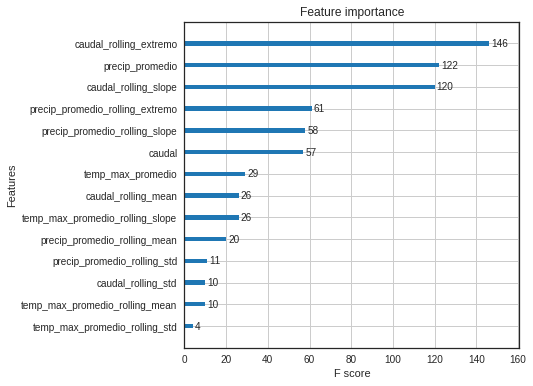

In [219]:
#Por como lo hice antes no muestra los nombres de las variables por defecto
mapper = {'f{0}'.format(i): v for i, v in enumerate(X.columns)}
mapped = {mapper[k]: v for k, v in xgb_clf.get_booster().get_fscore().items()}

fig, ax = plt.subplots(figsize=(6,6))

plot_importance(mapped, ax=ax)

plt.show()

En general, vemos que las variables relacionadas a caudal y precipitaciones son las más importantes: valor del día anterior, la tendencia y el porcentaje de eventos extremos en los últimos 7 días. La más importante de todas es el porcentaje de dias con caudal extremo en los días previos, seguido de las precipitaciones del día anterior y luego la tendencia del caudal.

Todas las variables relacionadas a temperatura tienen menos importancia para la predicción, igual que los promedios y desviaciones estándar de todas las variables (incluso de caudal y precipitación)

Tiene sentido que la más importante sea si hubo caudal extremo en los días previos, pero eso le resta utilidad a nuestro modelo. Si el río ya está está con caudal extremo y hubo un aluvión, ya no sirve mucho dar una alerta. Sería más interesante intentar predecir el primer día que hay caudal extremo para los casos en que el evento se extiende por más de un día.

In [189]:
precision_xgb, recall_xgb, threshold_xgb = metrics.precision_recall_curve(y_test, y_pred_xgb)

pos = np.argmin(np.abs(recall_xgb - .7))

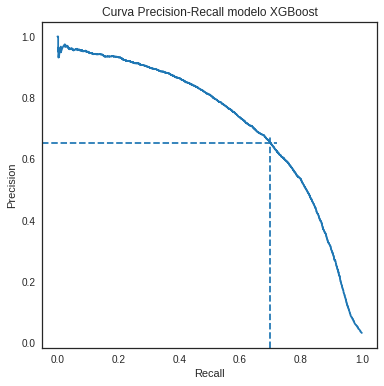

In [188]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(recall_xgb, precision_xgb)

ax.axvline(recall_xgb[pos], ymax=precision_xgb[pos], ls='--')
ax.axhline(precision_xgb[pos], xmax=recall_xgb[pos], ls='--')

ax.set_title('Curva Precision-Recall modelo XGBoost')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

plt.show()

In [191]:
recall_xgb[pos], precision_xgb[pos]

(0.7000255623721882, 0.6527231557621261)

Si quisieramos capturar el 70% de los eventos de caudales extremos, la precisión del modelo es de 65%.

Esto quiere decir que si usamos este modelo para dar una alerta de aluvión (asumiendo que en realidad hay un aluvión con nuestra definición de caudal extremo) nos equivocaríamos 35% de las veces. Además, otro 30% de las veces que hay un aluvión ni siquiera daríamos un aviso. Claramente necesitaríamos mejorar el modelo para usarlo en la vida real.

## Next steps

1. Tunear hiperparametros de XGBoost, aunque no creo que la ganancia sea tan considerable.
2. Probar predicción con LSTM.
3. Investigar uso de un LSTM+autoencoder para hacer feature extraction automático (como muestran [aquí](https://towardsdatascience.com/extreme-event-forecasting-with-lstm-autoencoders-297492485037))